In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display, Image
from scipy import stats
from sklearn.decomposition import PCA
import statsmodels.api as sm
from matplotlib_venn import venn3

**Comparison mTEC$^{hi}$- and mTEC$^{lo}$-specific TSRs**

We first define mTEC population-specific TSRs as those expressed in at least 2 samples from one mTEC population and not observed in any sample from the other population:

In [2]:
df_all=pd.read_pickle('df_all_new.pkl')
                      
df_High=df_all[(df_all.High>1) & (df_all.Low==0)]
print(f'All mTEC_hi-specific TSRs: {df_High.shape[0]}')
print(f'   Unique genes represented: {df_High.Gene_Name.unique().shape[0]}')
print(f'   Unique protein-coding genes represented: {df_High[df_High.Gene_Type=="protein-coding"].Gene_Name.unique().shape[0]}')

df_Low=df_all[(df_all.Low>1) & (df_all.High==0)]
print(f'\n All mTEC_lo-specific TSRs: {df_Low.shape[0]}')
print(f'   Unique genes represented: {df_Low.Gene_Name.unique().shape[0]}')
print(f'   Unique protein-coding genes represented: {df_Low[df_Low.Gene_Type=="protein-coding"].Gene_Name.unique().shape[0]}')

All mTEC_hi-specific TSRs: 1855
   Unique genes represented: 1500
   Unique protein-coding genes represented: 1281

 All mTEC_lo-specific TSRs: 2374
   Unique genes represented: 2011
   Unique protein-coding genes represented: 1740


In [3]:
tpm_lo=['pt212_lo_TPM','pt221_lo_TPM','pt226_lo_TPM','pt87_lo_TPM','pt214_lo_TPM']
tpm_hi=['pt212_hi_TPM','pt221_hi_TPM','pt226_hi_TPM','pt87_hi_TPM','pt214_hi_TPM']
tpm=np.hstack((tpm_hi,tpm_lo))

**Figure 2A-B**

In [4]:
df=df_High.append(df_Low) #Include only mTEC_hi- and mTEC_lo-specific TSRs
masked_df=1*(df[tpm]>0) #Binarize TSR expression by sample
i=0
for feature in ['TRA','Aire_dep','Fezf2_dep','Housekeeping','Aire_dep_TRA','Fezf2_dep_TRA','Other_TRA']:
    for name in tpm:
        #Calculate fraction of TSRs with feature for each sample
        percentage=np.sum(df[masked_df[name]==1][feature])/df[masked_df[name]==1].shape[0]
        df_temp=pd.DataFrame(np.vstack((feature,percentage,name.split('_')[0],name.split('_')[1])).T,columns=['Feature','Percentage','Patient','Hue'])
        if i==0:
            y=df_temp
        else:
            y=y.append(df_temp)
        i+=1
y.Percentage=y.Percentage.astype(float)

Ttest_relResult(statistic=-6.942728288795918, pvalue=0.002260634382551807)


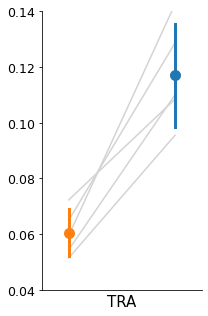

Ttest_relResult(statistic=2.9151180962472134, pvalue=0.0434550448169178)


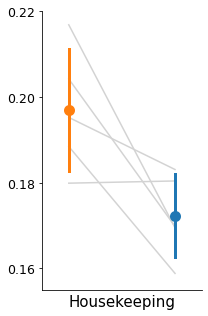

Ttest_relResult(statistic=-5.625236106918492, pvalue=0.004911489186920232)


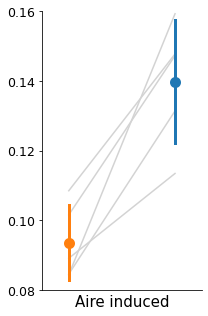

Ttest_relResult(statistic=-3.7101232342301453, pvalue=0.020651811499159463)


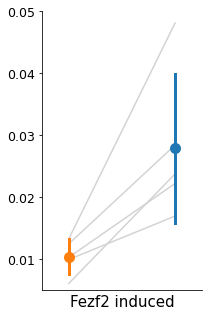

In [5]:
for feature in ['TRA','Housekeeping','Aire_dep','Fezf2_dep']:
    plt.figure(figsize=(3,4.5))
    for x in y.Patient.unique():
        plt.plot([0.5,0.1],[y[(y.Feature==feature) & (y.Patient==x) & (y.Hue=='hi')].Percentage,y[(y.Feature==feature) & (y.Patient==x) & (y.Hue=='lo')].Percentage],color='lightgray',zorder=1)

    plt.scatter(0.5,y[(y.Feature==feature) & (y.Hue=='hi')].Percentage.mean(),lw=5,zorder=3)
    plt.plot([0.5,0.5],[y[(y.Feature==feature) & (y.Hue=='hi')].Percentage.mean()+y[(y.Feature==feature) & (y.Hue=='hi')].Percentage.std(),
                   y[(y.Feature==feature) & (y.Hue=='hi')].Percentage.mean()-y[(y.Feature==feature) & (y.Hue=='hi')].Percentage.std()],lw=3,zorder=2)

    plt.scatter(.1,y[(y.Feature==feature) & (y.Hue=='lo')].Percentage.mean(),lw=5,zorder=3)
    plt.plot([.1,.1],[y[(y.Feature==feature) & (y.Hue=='lo')].Percentage.mean()+y[(y.Feature==feature) & (y.Hue=='lo')].Percentage.std(),
                   y[(y.Feature==feature) & (y.Hue=='lo')].Percentage.mean()-y[(y.Feature==feature) & (y.Hue=='lo')].Percentage.std()],lw=3,zorder=2)

    print(stats.ttest_rel(y[(y.Feature==feature) & (y.Hue=='lo')].Percentage,y[(y.Feature==feature) & (y.Hue=='hi')].Percentage))

    plt.xlim([0,.6])
    plt.xlabel(feature,fontsize=15)
    
    if feature=='Housekeeping':
        plt.ylim([.155,.22])
        plt.yticks(np.arange(.16,.24,.02))
    elif feature=='Aire_dep':
        plt.ylim(.095,.16)
        plt.xlabel('Aire induced')
        plt.yticks(np.arange(.08,.18,.02),fontsize=12.5)
    elif feature=='Fezf2_dep':
        plt.ylim([0.005,0.05])
        plt.yticks(np.arange(0.01,.06,.01))
        plt.xlabel('Fezf2 induced')
    elif feature=='TRA':
        plt.ylim(0.04,.14)
        plt.yticks(np.arange(0.04,.16,.02))
    plt.xticks([])
    plt.yticks(fontsize=12.5)
    #if feature=='AIRE':
     #   plt.ylabel('Frequency',fontsize=15)
      #  plt.yticks(np.arange(.1,.2,.02),fontsize=12.5)
    sns.despine() 
    plt.tight_layout()
    plt.show()
    plt.close()

**Figure 2C**

In [6]:
data2=[]
order=['Housekeeping','Aire_dep_TRA','Fezf2_dep_TRA','Other_TRA']
for gene_class in order:
    a=df_High[df_High[gene_class]==True].Gene_Name.shape[0]
    b=df_Low[df_Low[gene_class]==True].Gene_Name.shape[0]
    c=df_High.shape[0]-a
    d=df_Low.shape[0]-b 
    OR,p = stats.fisher_exact([[a, b], [c,d]])
    lower_ci,upper_ci=sm.stats.Table2x2(np.asarray([[a,b],[c,d]])).oddsratio_confint(alpha=0.05, method='normal')
    data2.append([gene_class,OR,p,lower_ci,upper_ci])
data2=pd.DataFrame(data2,columns=['Class','OR','p','lower','upper']).sort_values(by='OR',ascending=False)
data2.index=data2.Class
data2=data2.sort_values(by='OR')
data2

,Class,OR,p,lower,upper
Class,,,,,
Housekeeping,Housekeeping,0.870170,8.159610e-02,0.744285,1.017345
Other_TRA,Other_TRA,1.948609,1.573415e-05,1.438645,2.639342
Aire_dep_TRA,Aire_dep_TRA,2.528739,1.400153e-07,1.774107,3.604359
Fezf2_dep_TRA,Fezf2_dep_TRA,14.889738,1.062722e-06,3.506022,63.235277


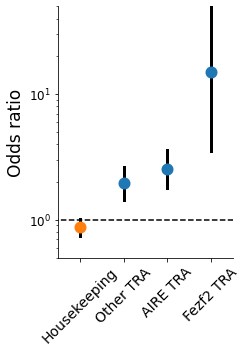

In [7]:
plt.figure(figsize=(3.5,5))
plt.plot([-1,10],[1,1],'--k')
colors=np.vstack(([sns.color_palette()[1]],[sns.color_palette()[0]]*3))
for i,x in enumerate(data2.Class):
    plt.plot([i,i],data2.loc[x][['lower','upper']],'k',lw=3)
    plt.scatter(i,data2.loc[x].OR,lw=6,zorder=5,color=colors[i])
plt.xlim([-.5,3.5])
plt.xticks(np.arange(4),['Housekeeping','Other TRA','AIRE TRA','Fezf2 TRA'],rotation=45,fontsize=14)
plt.xlabel('')
plt.ylim([.5,50])
plt.legend('',frameon=False)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.ylabel('Odds ratio',fontsize=17)
sns.despine()
plt.tight_layout()
plt.show()
plt.close()

**Figure 2D**

Ttest_relResult(statistic=19.640155477246118, pvalue=3.963717569751997e-05)


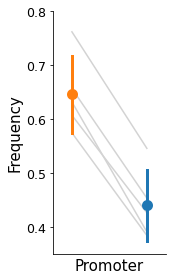

In [8]:

df=df_High.append(df_Low)
masked_df=1*(df[tpm]>0)
i=0
for feature in ['Annotations_short']:
    for name in tpm:
        if df[masked_df[name]==1].shape[0]>5:
            percentage=np.sum(df[masked_df[name]==1][feature]=='promoter-TSS')/df[masked_df[name]==1].shape[0]
            x=pd.DataFrame(np.vstack((feature,percentage,name.split('_')[0],name.split('_')[1])).T,columns=['Feature','Percentage','Patient','Hue'])
            if i==0:
                y=x
            else:
                y=y.append(x)
            i+=1
y.Percentage=y.Percentage.astype(float)

plt.figure(figsize=(2.5,4))
feature='Annotations_short'
for x in y.Patient.unique():
    plt.plot([0.5,0.1],[y[(y.Feature==feature) & (y.Patient==x) & (y.Hue=='hi')].Percentage,y[(y.Feature==feature) & (y.Patient==x) & (y.Hue=='lo')].Percentage],color='lightgray',zorder=1)

plt.scatter(0.5,y[(y.Feature==feature) & (y.Hue=='hi')].Percentage.mean(),lw=5,zorder=3)
plt.plot([0.5,0.5],[y[(y.Feature==feature) & (y.Hue=='hi')].Percentage.mean()+y[(y.Feature==feature) & (y.Hue=='hi')].Percentage.std(),
               y[(y.Feature==feature) & (y.Hue=='hi')].Percentage.mean()-y[(y.Feature==feature) & (y.Hue=='hi')].Percentage.std()],lw=3,zorder=2)

plt.scatter(.1,y[(y.Feature==feature) & (y.Hue=='lo')].Percentage.mean(),lw=5,zorder=3)
plt.plot([.1,.1],[y[(y.Feature==feature) & (y.Hue=='lo')].Percentage.mean()+y[(y.Feature==feature) & (y.Hue=='lo')].Percentage.std(),
               y[(y.Feature==feature) & (y.Hue=='lo')].Percentage.mean()-y[(y.Feature==feature) & (y.Hue=='lo')].Percentage.std()],lw=3,zorder=2)


print(stats.ttest_rel(y[(y.Feature==feature) & (y.Hue=='lo')].Percentage,y[(y.Feature==feature) & (y.Hue=='hi')].Percentage))

plt.xlim([0,.6])
plt.ylim([.35,.8])
plt.xticks([])
plt.yticks(fontsize=12.5)
plt.xlabel('')
plt.xlabel('Promoter',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
sns.despine() 
plt.tight_layout()
plt.show()
plt.close()

**Figure 2E**

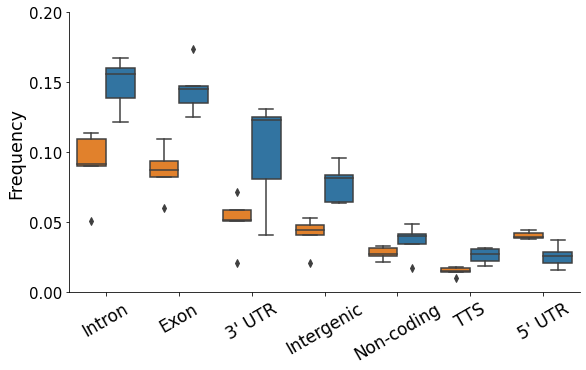

p-values:
intron - 0.01
exon - 0.001
3' UTR - 0.011
Intergeni - 0.005
non-coding - 0.153
TTS - 0.002
5' UTR - 0.012


In [9]:
df=df_High.append(df_Low)
masked_df=1*(df[tpm]>0)
feature='Annotations_short'
for i,name in enumerate(tpm):
    a,b=np.unique(df[masked_df[name]==1][feature],return_counts=1)
    x=pd.DataFrame(np.vstack((a,b/sum(b),[name]*len(a),[name.split('_')[1]]*len(a))).T,columns=['Feature','Percentage','Patient','Hue'])
    if i==0:
        y=x
    else:
        y=y.append(x)

order=['intron','exon',"3' UTR",'Intergeni','non-coding','TTS',"5' UTR"]
plt.figure(figsize=(8.25,5.25))
sns.boxplot(x='Feature',y='Percentage',hue='Hue',data=y[y.Feature!='promoter-TSS'],order=order,
           hue_order=['lo','hi'],palette=[sns.color_palette()[1],sns.color_palette()[0]])
plt.xticks(np.arange(7),['Intron','Exon',"3' UTR",'Intergenic','Non-coding','TTS',"5' UTR"],rotation=30,fontsize=17)
plt.yticks(np.arange(0,.25,.05),fontsize=15)
plt.xlabel('')
plt.ylabel('Frequency',fontsize=17.5)
plt.ylim([0,0.2])
#plt.yscale('log')
sns.despine()
plt.tight_layout()
plt.legend('',frameon=False)
plt.show()
plt.close()
print('p-values:')
for x in order:
    print(x,'-',round(stats.ttest_rel(y[(y.Feature==x) & (y.Hue=='hi')].Percentage,y[(y.Feature==x) & (y.Hue=='lo')].Percentage)[1],3))

**Figure 2F**

In [10]:
i=0
for feature in ['promoter-TSS',"5' UTR",'Other']:
    if feature !='Other':
        a,b=np.unique(df_High.Annotations_short,return_counts=1)
        high_promotor=sum(b[(a==feature) ])
        a,b=np.unique(df_Low.Annotations_short,return_counts=1)
        low_promotor=sum(b[(a==feature)])
    else:
        a,b=np.unique(df_High.Annotations_short,return_counts=1)
        high_promotor=sum(b[(a!='promoter-TSS') & (a!="5' UTR")])
        a,b=np.unique(df_Low.Annotations_short,return_counts=1)
        low_promotor=sum(b[(a!='promoter-TSS') & (a!="5' UTR")])
    c=df_High.shape[0]-high_promotor
    d=df_Low.shape[0]-low_promotor
    a=high_promotor
    b=low_promotor
    odd,pv=stats.fisher_exact([[a,b], [c,d]])
    lower_ci,upper_ci=sm.stats.Table2x2(np.asarray([[a,b],[c,d]])).oddsratio_confint(alpha=0.05, method='normal')
    if feature=='promoter-TSS':
        feature='Promoter'
    if i==0:
        df=np.hstack((feature,odd,pv,lower_ci,upper_ci))
    else:
        df=np.vstack((df,np.hstack((feature,odd,pv,lower_ci,upper_ci))))
    i+=1
df=pd.DataFrame(df,columns=['Feature','OR','p','lower','upper'])
df.OR=df.OR.astype(float)
df.lower=df.lower.astype(float)
df.upper=df.upper.astype(float)
df.index=df.Feature
df

,Feature,OR,p,lower,upper
Feature,,,,,
Promoter,Promoter,0.452630,1.3008371355647759e-36,0.399911,0.512298
5' UTR,5' UTR,0.571321,0.002013092969293336,0.399498,0.817044
Other,Other,2.393075,1.3286826442517454e-43,2.112635,2.710741


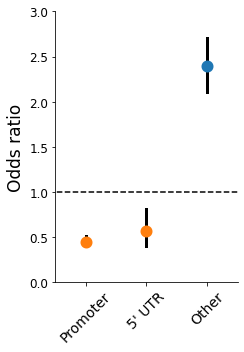

In [11]:
plt.figure(figsize=(3.5,5))
plt.plot([-1,10],[1,1],'--k')
colors=np.vstack(([sns.color_palette()[1]]*2,[sns.color_palette()[0]]))
for i,x in enumerate(df.Feature):
    plt.plot([i,i],df.loc[x][['lower','upper']],'k',lw=3)
    plt.scatter(i,df.loc[x].OR,lw=6,zorder=5,color=colors[i])
plt.xlim([-.5,2.5])
plt.xticks(np.arange(3),['Promoter',"5' UTR",'Other'],rotation=45,fontsize=14)
plt.xlabel('')
plt.ylim([0,3])
plt.legend('',frameon=False)
plt.yticks(fontsize=12)
plt.ylabel('Odds ratio',fontsize=17)
sns.despine()
plt.tight_layout()
plt.show()
plt.close()

**Figure 2G**

In [12]:
df_all_combined=pd.read_pickle('Fantom5_Combined.pkl')
print(f'All mTEC and Fantom5 TSRs: {df_all_combined.shape[0]}')
print(f'   Unique genes represented: {df_all_combined.Gene_Name.unique().shape[0]}')
print(f'   Unique protein-coding genes represented: {df_all_combined[df_all_combined.Gene_Type=="protein-coding"].Gene_Name.unique().shape[0]}')

All mTEC and Fantom5 TSRs: 81262
   Unique genes represented: 21094
   Unique protein-coding genes represented: 16062


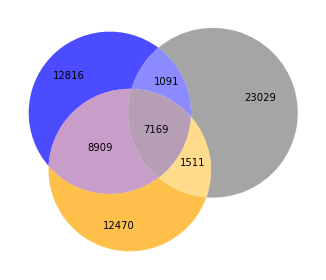

TSRs shared between Fantom5 and mTEC_hi: 8260 (27.5%)
TSRs shared between Fantom5 and mTEC_lo: 8680 (28.9%)
TSRs shared between mTEC_hi and mTEC_lo: 16078 (36.6%)


In [13]:
drrs=[]
los=[]
his=[]
df_all_combined=df_all_combined[df_all_combined.Gene_Type=='protein-coding']
for x in df_all_combined.Samples:
    drr=0
    lo=0
    hi=0
    for y in x.split(','):
        if 'DRR' in y:
            drr=1
        else:
            if 'hi' in y:
                hi=1
            elif 'lo' in y:
                lo=1
    drrs.append(drr)
    los.append(lo)
    his.append(hi)
x=pd.DataFrame(np.vstack((drrs,los,his)).T,columns=['Fantom','Low','High'])

fantom=x[(x.Fantom==1) & (x.Low==0) & (x.High==0)].shape[0]
low=x[(x.Fantom==0) & (x.Low==1) & (x.High==0)].shape[0]
high=x[(x.Fantom==0) & (x.Low==0) & (x.High==1)].shape[0]
low_hi=x[(x.Fantom==0) & (x.Low==1) & (x.High==1)].shape[0]
fantom_lo=x[(x.Fantom==1) & (x.Low==1) & (x.High==0)].shape[0]
fantom_hi=x[(x.Fantom==1) & (x.Low==0) & (x.High==1)].shape[0]
al=x[(x.Fantom==1) & (x.Low==1) & (x.High==1)].shape[0]

c=venn3(subsets = (high, fantom, fantom_hi,low,low_hi,fantom_lo,al),alpha=0.7,set_colors=('blue','gray','orange'),set_labels = ('', '', ''))
plt.tight_layout()
plt.show()
plt.close()

print(f'TSRs shared between Fantom5 and mTEC_hi: {al+fantom_hi} ({round((al+fantom_hi)/(high+fantom_hi+low_hi+al)*100,1)}%)')
print(f'TSRs shared between Fantom5 and mTEC_lo: {(al+fantom_lo)} ({round((al+fantom_lo)/(low+fantom_lo+low_hi+al)*100,1)}%)')
print(f'TSRs shared between mTEC_hi and mTEC_lo: {(al+low_hi)} ({round((al+low_hi)/(al+low_hi+high+low+fantom_hi+fantom_lo)*100,1)}%)')

**Figure 2H**

In [14]:
drr=['DRR009521','DRR009498', 'DRR009510', 'DRR009537', 'DRR009542', 'DRR009546', 'DRR009550', 'DRR009569', 'DRR009596', 'DRR009611', 'DRR009617', 'DRR009619', 'DRR009612']
tissue=["other",'Brain', 'Colon', 'Heart', 'Kidney', 'Liver', 'Lung', 'Ovary', 'Small Intestine', 'Testis1', 'Thymus', 'Thyroid', 'Testis2']

In [15]:
mtec=['pt212_lo','pt221_lo','pt226_lo','pt87_lo','pt214_lo','pt212_hi','pt221_hi','pt226_hi','pt87_hi','pt214_hi']
mtec_lo=['pt212_lo','pt221_lo','pt226_lo','pt87_lo','pt214_lo']
mtec_hi=['pt212_hi','pt221_hi','pt226_hi','pt87_hi','pt214_hi']
samples=np.hstack((mtec,drr))
for x in samples:
    count=[]
    for names in df_all_combined.Samples:
        if x in names:
            count.append(1)
        else:
            count.append(0)
    df_all_combined.insert(df_all_combined.shape[1], x, count)
df_all_combined=df_all_combined.assign(mTEC_lo=1*(df_all_combined[mtec_lo].sum(axis=1)>0))
df_all_combined=df_all_combined.assign(mTEC_hi=1*(df_all_combined[mtec_hi].sum(axis=1)>0))

In [16]:
data=df_all_combined[np.hstack(('mTEC_hi','mTEC_lo',drr))]
data.columns=np.hstack(('mTEC_hi','mTEC_lo',tissue))

data=data.assign(Bowel=1*((data.Colon+data['Small Intestine'])>0))
data=data.drop(columns=['Colon','Small Intestine'])

data=data.assign(Testis=1*((data.Testis1+data.Testis2)>0))
data=data.drop(columns=['Testis1','Testis2'])

data=data.drop(columns=['other'])

data=1*(data>0)

matrix=pd.DataFrame(np.zeros((len(data.columns),len(data.columns))),columns=data.columns,index=data.columns)
for i,x in enumerate(data.columns):
    data_i=data.drop(columns=x)
    for j,y in enumerate(data.columns):
        if i!=j:
            unique_out=data_i[(data_i.sum(axis=1)==1) & (data_i[y]==1)].shape[0]
            unique_with=data[(data.sum(axis=1)==2) & (data[x]==1) & (data[y]==1)].shape[0]
            matrix.loc[y][x]=unique_with/(unique_out+1)
        elif i==j:
            matrix.loc[y][x]=np.nan

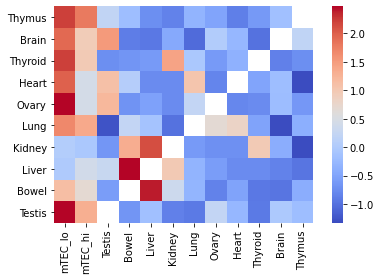

In [17]:
matrix=matrix.loc[matrix.index[~matrix.index.isin(['mTEC_hi','mTEC_lo'])]]
matrix=pd.DataFrame(stats.zscore(matrix,nan_policy='omit',axis=1),columns=matrix.columns,index=matrix.index)
matrix=matrix[matrix.mean().sort_values(ascending=False).index].loc[matrix.mean().sort_values(ascending=False).index[2::][::-1]]
sns.heatmap(matrix,
           cmap='coolwarm',square=1,robust=1)
plt.tight_layout()
plt.show()
plt.close()

Ttest_relResult(statistic=3.35220203908142, pvalue=0.008493760351261802)


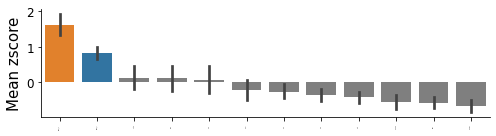

In [18]:
plt.figure(figsize=(7,2))
print(stats.ttest_rel(matrix['mTEC_lo'],matrix['mTEC_hi']))
bar=pd.DataFrame(matrix.mean().sort_values(ascending=True),columns=['med'])
bar.med=bar.med.astype(float)
order=matrix.mean().sort_values(ascending=False).index
sns.barplot(x='variable',y='value',data=matrix.melt(),order=order,palette=np.vstack((sns.color_palette()[1],sns.color_palette()[0],[sns.color_palette()[7]]*(bar.shape[0]-2))),ci=68)
plt.xticks(rotation=90)
sns.despine()
plt.xlabel('')
plt.xticks(fontsize=0)
plt.yticks(fontsize=12)
plt.ylabel('Mean zscore',fontsize=15)
plt.tight_layout()
plt.show()
plt.close()